In [2]:
import pandas as pd
import seaborn as sns
import dynamo
import dynamo as dyn
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
from benchmark_utils import *
dyn_adata = dyn.sample_data.zebrafish()
print("original data shape:", dyn_adata.shape)

import numpy as np



|-----> Downloading data to ./data/zebrafish.h5ad


original data shape: (4181, 16940)


## Convert Data for R Seurat inputs

In [3]:
import scipy
import scipy.io
dyn.preprocessing.convert_layers2csr(dyn_adata)
dyn.preprocessing.unique_var_obs_adata(dyn_adata)
scipy.io.mmwrite("counts.mtx", dyn_adata.X)
scipy.io.mmwrite("spliced.mtx", dyn_adata.layers["spliced"])
scipy.io.mmwrite("unspliced.mtx", dyn_adata.layers["unspliced"])

In [4]:
pd.Series(dyn_adata.obs_names).to_csv("./data/cell_names.csv")
pd.Series(dyn_adata.var_names).to_csv("./data/var_names.csv")

In [11]:
seurat_X_pca = pd.read_csv("./R-seurat-test/X_pca.csv")

In [47]:
seurat_X_pca[:2]

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50
TGCCAAATCACCACCT-1-0,-5.857340,2.867679,0.169394,0.86043,0.185787,0.855904,-0.13344,3.436429,-0.656718,-1.001899,...,0.439428,-0.271046,0.233556,0.842144,0.126444,-0.300330,-0.259993,0.201506,0.691337,-0.898238
AAATGCCAGGAGCGTT-1-0,-5.925883,5.597495,-0.900045,-10.14316,0.501072,-4.512660,0.89789,2.204267,-1.688371,-1.772579,...,-0.089032,-1.277523,-0.383998,0.783514,-0.988206,3.932976,0.766193,-3.019138,-1.428712,0.049915


<AxesSubplot:ylabel='Count'>

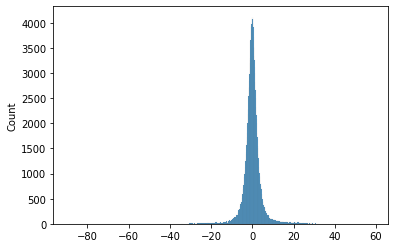

In [13]:
X_pca_arr = seurat_X_pca.to_numpy().flatten()
sns.histplot(X_pca_arr)

In [26]:
print(seurat_X_pca.shape)
print(dyn_adata.shape)

(4181, 50)
(4181, 16940)


In [27]:
dyn_adata.obs_names[:10]

Index(['TGCCAAATCACCACCT-1-0', 'AAATGCCAGGAGCGTT-1-0', 'CAGCGACAGAGAACAG-1-0',
       'GGGACCTGTGACCAAG-1-0', 'TCCCGATAGTGTGGCA-1-0', 'CAGAGAGAGGCGATAC-1-0',
       'AACTGGTAGTGGAGAA-1-0', 'ATTGGACGTCTAGCGC-1-0', 'TGGGCGTCACCAGGTC-1-0',
       'TTGGCAAAGGGCTTCC-1-0'],
      dtype='object', name='index')

In [28]:
seurat_adata = dyn.sample_data.zebrafish()
dyn.preprocessing.unique_var_obs_adata(seurat_adata)
print(seurat_X_pca.shape)
print(seurat_adata.shape)
print(set(seurat_X_pca.index) - set(seurat_adata.obs_names))
print(set(seurat_adata.obs_names) - set(seurat_X_pca.index))

|-----> Downloading data to ./data/zebrafish.h5ad


(4181, 50)
(4181, 16940)
set()
set()


In [42]:

# reorder seurat_X_pca index order and set to X_pca
seurat_adata.obsm["X_pca"] = seurat_X_pca.loc[seurat_adata.obs_names, :].to_numpy()
# print(seurat_adata.obsm)


|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0020s]


<Figure size 1000x1000 with 0 Axes>

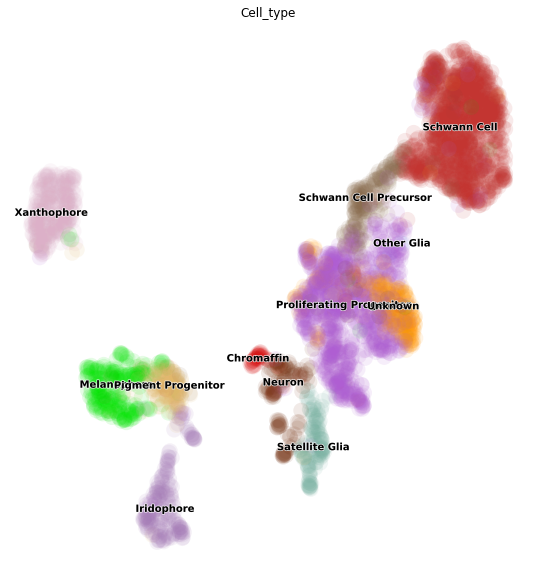

In [46]:

dyn.tl.reduceDimension(seurat_adata, basis="pca")
dyn.pl.umap(seurat_adata, color="Cell_type", figsize=(10, 10))